# Comparison of models to predict sells

## Introduction 


We try some easy models to predict the sells of "a famous milk company". 
We study the impact of the MAPE metric with some plots.
We'll also try to see the differences between a time model like ARIMA and usual models like XGB,RF or Gradient Boosting. 
Unfortunately, data are private and not acessible.

The data is made of informations about :
- the supermarket seller : Enseigne
- the date of the observations : Week, Year, Date
- the type of product sold : MK1 
- the type of discount : Meca and Pack
- the amount of discount : Plage
- the number of days the discount is in the supermarket : Days_uplifts

Choose the supermarket and the kind of product you would like to predict by filling the following variables :
The product names are :
 - 'F0W'
 - 'F56'
 - 'F8M'
 - 'FHG'
 - 'VR3'
 
The market names are 
- 'Auchan' 
- 'Carrefour'
- 'Carrefour Market'
- 'Casino SM'
- 'Cora'
- 'Geant'
- 'Monoprix'
- 'SM Match  Prospectus'
- 'Systeme U'

If no change, let's assume that we want to stuy the product 'F0W' in the market 'Carrefour Market'

In [620]:
name_market='Carrefour Market'
name_product='F0W'

In [621]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from math import sqrt
import matplotlib
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
import xgboost

In [647]:
df=pd.read_excel('/Users/newuser/Downloads/Waters.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 12 columns):
Client 4        8685 non-null object
Enseigne        8685 non-null object
Date            8685 non-null float64
Week            8685 non-null int64
Year            8685 non-null int64
MG1             8685 non-null object
Sell_Out        8685 non-null float64
Theme           2963 non-null object
Mecanisme       2963 non-null object
Pack            2963 non-null object
Days_Uplifts    2963 non-null float64
Plage           2963 non-null float64
dtypes: float64(4), int64(2), object(6)
memory usage: 814.3+ KB


In [746]:
# ex: change 2014.01 to 2014-01-08
df['Date']=pd.to_datetime(df.Year.astype(str), format='%Y') \
+ pd.to_timedelta(df.Week.mul(7).astype(str) + ' days')
df=df.sort_values(by=['Date'])
#df_time=pd.to_datetime(new_df.Year.astype(str), format='%Y') + pd.to_timedelta(new_df.Week.mul(7).astype(str) + ' days')

In [747]:
df.head()

,Client 4,Enseigne,Date,Week,Year,MG1,Sell_Out,Theme,Mecanisme,Pack,Days_Uplifts,Plage
0,Carrefour,Carrefour,2014-01-08,1,2014,FHG,200874.666667,NaN,NaN,NaN,NaN,NaN
2,Carrefour,Carrefour,2014-01-08,1,2014,VR3,395137.000000,(vide),Lots Virtuels,2 packs,4.0,0.3
3,Carrefour,Carrefour,2014-01-08,1,2014,F0W,255348.000000,NaN,NaN,NaN,NaN,NaN
4,Carrefour,Carrefour,2014-01-08,1,2014,F8M,234637.000000,NaN,NaN,NaN,NaN,NaN
5,Carrefour,Carrefour Market,2014-01-08,1,2014,FHG,196520.666667,NaN,NaN,NaN,NaN,NaN


In [748]:
df2=df.drop(['Theme','Client 4'],axis=1)

# 0-1 for categorial variables
new_df=pd.get_dummies(df2['Enseigne'],prefix='Ens')
new_df2=pd.get_dummies(df2['MG1'],prefix='MG1')
new_df3=pd.get_dummies(df2['Mecanisme'],prefix='Meca',dummy_na=True)
new_df4=pd.get_dummies(df2['Pack'],prefix='Pack',dummy_na=True)

# Concatenation of data frame
int_df1 = pd.concat([new_df,new_df2],axis=1)
int_df2 = pd.concat([new_df3,new_df4],axis=1)
int_df = pd.concat([int_df1,int_df2],axis=1)
new_df=pd.concat([int_df,df2],axis=1)

# Deletion of variables that have been 
new_df=new_df.drop(['Enseigne','MG1','Mecanisme','Pack'],axis=1)
new_df=new_df.fillna(0)

In [749]:
def analysis_on_one_market_and_one_product(df,name_market,name_product):
    new_df=df[df['Ens_'+name_market]==1]
    new_df=new_df[new_df['MG1_'+name_product]==1]
    new_df=new_df.drop(['Ens_Auchan', 'Ens_Carrefour', 'Ens_Carrefour Market', 'Ens_Casino SM',
       'Ens_Cora', 'Ens_Geant', 'Ens_Monoprix', 'Ens_SM Match  Prospectus',
       'Ens_Systeme U','MG1_F0W', 'MG1_F56', 'MG1_F8M', 'MG1_FHG', 'MG1_VR3'],axis=1)
    return(new_df)

new_df=analysis_on_one_market_and_one_product(new_df,name_market,name_product)
new_df.head()

,Meca_Cagnottage,Meca_Lots Virtuels,Meca_Multiple,Meca_RI,Meca_nan,Pack_1 pack,Pack_2 packs,Pack_3 packs,Pack_autre,Pack_nan,Date,Week,Year,Sell_Out,Days_Uplifts,Plage
9,0,0,0,0,1,0,0,0,0,1,2014-01-08,1,2014,229458.666667,0.0,0.0
50,0,0,0,0,1,0,0,0,0,1,2014-01-15,2,2014,242696.000000,0.0,0.0
98,0,0,0,0,1,0,0,0,0,1,2014-01-22,3,2014,226044.666667,0.0,0.0
141,0,0,0,0,1,0,0,0,0,1,2014-01-29,4,2014,228367.333333,0.0,0.0
189,0,0,0,0,1,0,0,0,0,1,2014-02-05,5,2014,256786.000000,0.0,0.0


In [750]:
# Sort Data Frame by date
new_df=new_df.sort_values(by='Date')
new_df.index=new_df['Date']
new_df=new_df.drop('Date',axis=1)
# Get Y 
Y=new_df['Sell_Out']

In [751]:
new_df.head()

,Meca_Cagnottage,Meca_Lots Virtuels,Meca_Multiple,Meca_RI,Meca_nan,Pack_1 pack,Pack_2 packs,Pack_3 packs,Pack_autre,Pack_nan,Week,Year,Sell_Out,Days_Uplifts,Plage
Date,,,,,,,,,,,,,,,
2014-01-08,0,0,0,0,1,0,0,0,0,1,1,2014,229458.666667,0.0,0.0
2014-01-15,0,0,0,0,1,0,0,0,0,1,2,2014,242696.000000,0.0,0.0
2014-01-22,0,0,0,0,1,0,0,0,0,1,3,2014,226044.666667,0.0,0.0
2014-01-29,0,0,0,0,1,0,0,0,0,1,4,2014,228367.333333,0.0,0.0
2014-02-05,0,0,0,0,1,0,0,0,0,1,5,2014,256786.000000,0.0,0.0


In [752]:
# Separate into train and test set
# The goal is to predict 2017 sells
new_df_train=new_df[new_df['Year']<2017]
new_df_test=new_df[new_df['Year']>=2017]
Y_train=new_df_train['Sell_Out']
Y_test=new_df_test['Sell_Out']

# Drop Y from explained variables
new_df_train=new_df_train.drop('Sell_Out',axis=1)
new_df_test=new_df_test.drop('Sell_Out',axis=1)

# Get line names 
index_train=new_df_train.index
index_test=new_df_test.index
new_df_test.head()

,Meca_Cagnottage,Meca_Lots Virtuels,Meca_Multiple,Meca_RI,Meca_nan,Pack_1 pack,Pack_2 packs,Pack_3 packs,Pack_autre,Pack_nan,Week,Year,Days_Uplifts,Plage
Date,,,,,,,,,,,,,,
2017-01-08,0,0,0,0,1,0,0,0,0,1,1,2017,0.0,0.0
2017-01-15,1,0,0,0,0,1,0,0,0,0,2,2017,7.0,0.3
2017-01-22,1,0,0,0,0,1,0,0,0,0,3,2017,1.0,0.3
2017-01-29,0,0,0,0,1,0,0,0,0,1,4,2017,0.0,0.0
2017-02-05,0,1,0,0,0,0,1,0,0,0,5,2017,6.0,0.5


Lets predict the 2017 sells, training the model with the 2014-2016 sells

## Random Forest

In [753]:
rfg=RandomForestRegressor(n_estimators=10, criterion='mae')
rfg_fitted=rfg.fit(new_df_train,Y_train)

In [754]:
from sklearn import metrics
def rmse(predictions,true_y):
    return(np.sqrt(((predictions - true_y) ** 2).mean()))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

---------On test set---------
RMSE = 133267.4931937997
MAPE = 19.073696787718077
MAE= 81906.67407407408
MSE= 17760224742.159447
R2= 0.8411295553417998


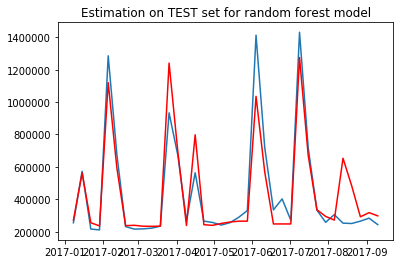

In [755]:
y_pred=rfg_fitted.predict(new_df_test)
print('---------On test set---------')

print('RMSE = {}'.format(rmse(y_pred,Y_test)))
print('MAPE = {}'.format(mean_absolute_percentage_error(Y_test, y_pred)))
print('MAE= {}'.format(metrics.mean_absolute_error(Y_test, y_pred)))
print('MSE= {}'.format(metrics.mean_squared_error(Y_test, y_pred)))
print('R2= {}'.format(metrics.r2_score(Y_test, y_pred)))

pyplot.plot(Y_test)
pyplot.plot(pd.DataFrame(index=index_test, data=y_pred), color='red')
pyplot.title('Estimation on TEST set for random forest model')
pyplot.show()

---------On train set---------
RMSE = 72218.92522123818
MAPE = 8.040604188003268
MAE= 34475.66326963904
MSE= 5215573160.110791
R2= 0.9179581315299948


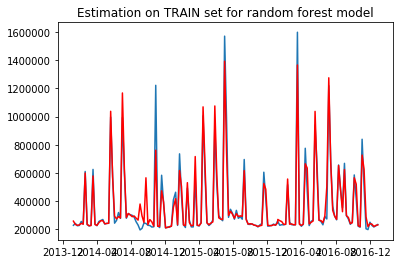

In [756]:
y_pred=rfg_fitted.predict(new_df_train)
print('---------On train set---------')
print('RMSE = {}'.format(rmse(y_pred,Y_train)))
print('MAPE = {}'.format(mean_absolute_percentage_error(Y_train, y_pred)))
print('MAE= {}'.format(metrics.mean_absolute_error(Y_train, y_pred)))
print('MSE= {}'.format(metrics.mean_squared_error(Y_train, y_pred)))
print('R2= {}'.format(metrics.r2_score(Y_train, y_pred)))

pyplot.plot(Y_train)
pyplot.plot(pd.DataFrame(index=index_train, data=y_pred), color='red')
pyplot.title('Estimation on TRAIN set for random forest model')
pyplot.show()

In [757]:
df_var_importance=pd.DataFrame({'name_variable':new_df.drop('Sell_Out',axis=1).columns,'score (the higher the better)':rfg_fitted.feature_importances_})
df_var_importance.sort_values(by=['score (the higher the better)'])

,name_variable,score (the higher the better)
2,Meca_Multiple,0.000000
8,Pack_autre,0.000000
9,Pack_nan,0.000118
4,Meca_nan,0.001474
7,Pack_3 packs,0.003855
3,Meca_RI,0.005628
1,Meca_Lots Virtuels,0.016960
6,Pack_2 packs,0.019824
5,Pack_1 pack,0.021408
0,Meca_Cagnottage,0.029386


This Data Frame tells us what variables have the biggest impact on the predictions. The Week variable influence a lot our results, because it allows to distinguish holidays, or religious event like christmas, where the sells can vary a lot. 
Moreover, in the Carrefour and Systeme U markets, the choice of the kind of discounts will affect the amount of sells more than in the other markets. 
The variable "Pack" is not very helpful for this model.

## Gradient Boosting

In [758]:
from sklearn.ensemble import GradientBoostingRegressor

In [759]:
GBR=GradientBoostingRegressor(loss='lad',n_estimators=100)
GBR_fitted=GBR.fit(new_df_train,Y_train)

---------On test set---------
RMSE = 206907.74952236592
MAPE = 19.38443646329531
MAE= 105288.09603134134
MSE= 42810816812.41012
R2= 0.6170446262978214

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x10b400d30>>
Traceback (most recent call last):
  File "/Users/newuser/anaconda3/lib/python3.6/site-packages/xgboost/core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x121d799e8>>
Traceback (most recent call last):
  File "/Users/newuser/anaconda3/lib/python3.6/site-packages/xgboost/core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x122199630>>
Traceback (most recent call last):
  File "/Users/newuser/anaconda3/lib/python3.6/site-packages/xgboost/core.py", line 368, in __del__


    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


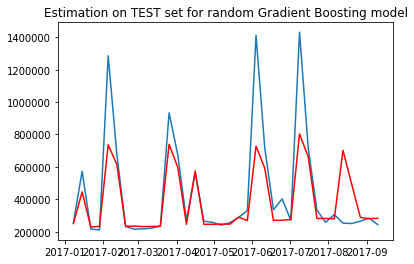

In [760]:
y_pred=GBR_fitted.predict(new_df_test)
print('---------On test set---------')
print('RMSE = {}'.format(rmse(y_pred,Y_test)))
print('MAPE = {}'.format(mean_absolute_percentage_error(Y_test, y_pred)))
print('MAE= {}'.format(metrics.mean_absolute_error(Y_test, y_pred)))
print('MSE= {}'.format(metrics.mean_squared_error(Y_test, y_pred)))
print('R2= {}'.format(metrics.r2_score(Y_test, y_pred)))

pyplot.plot(Y_test)
pyplot.plot(pd.DataFrame(index=index_test, data=y_pred), color='red')
pyplot.title('Estimation on TEST set for random Gradient Boosting model')
pyplot.show()

---------On train set---------
RMSE = 136357.13987324046
MAPE = 10.878258807073582
MAE= 55570.04503668273
MSE= 18593269594.41047
R2= 0.7075246513348561


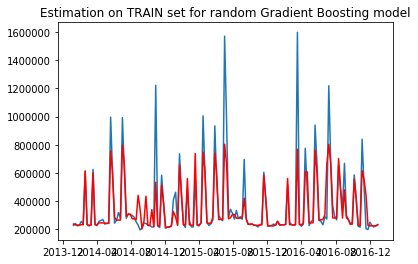

In [761]:
y_pred=GBR_fitted.predict(new_df_train)
print('---------On train set---------')
print('RMSE = {}'.format(rmse(y_pred,Y_train)))
print('MAPE = {}'.format(mean_absolute_percentage_error(Y_train, y_pred)))
print('MAE= {}'.format(metrics.mean_absolute_error(Y_train, y_pred)))
print('MSE= {}'.format(metrics.mean_squared_error(Y_train, y_pred)))
print('R2= {}'.format(metrics.r2_score(Y_train, y_pred)))

pyplot.plot(Y_train)
pyplot.plot(pd.DataFrame(index=index_train, data=y_pred), color='red')
pyplot.title('Estimation on TRAIN set for random Gradient Boosting model')
pyplot.show()

In [762]:
df_var_importance=pd.DataFrame({'name_variable':new_df.drop('Sell_Out',axis=1).columns,'score (the higher the better)':GBR_fitted.feature_importances_})
df_var_importance.sort_values(by=['score (the higher the better)'])

,name_variable,score (the higher the better)
2,Meca_Multiple,0.000000
3,Meca_RI,0.000000
7,Pack_3 packs,0.000000
8,Pack_autre,0.000000
0,Meca_Cagnottage,0.004213
9,Pack_nan,0.005215
5,Pack_1 pack,0.005504
1,Meca_Lots Virtuels,0.010663
4,Meca_nan,0.015006
6,Pack_2 packs,0.020376


In [763]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [764]:
xgb_fitted=xgb.fit(new_df_train,Y_train)

---------On test set---------
RMSE = 131895.77740764152
MAPE = 17.939353178732656
MAE= 76940.52445023136
MSE= 17396496097.966118
R2= 0.8443832152631602


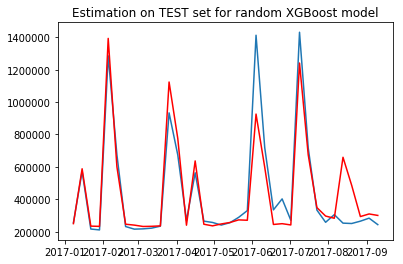

In [765]:
y_pred=xgb_fitted.predict(new_df_test)
print('---------On test set---------')
print('RMSE = {}'.format(rmse(y_pred,Y_test)))
print('MAPE = {}'.format(mean_absolute_percentage_error(Y_test, y_pred)))
print('MAE= {}'.format(metrics.mean_absolute_error(Y_test, y_pred)))
print('MSE= {}'.format(metrics.mean_squared_error(Y_test, y_pred)))
print('R2= {}'.format(metrics.r2_score(Y_test, y_pred)))

pyplot.plot(Y_test)
pyplot.plot(pd.DataFrame(index=index_test, data=y_pred), color='red')
pyplot.title('Estimation on TEST set for random XGBoost model')
pyplot.show()

---------On train set---------
RMSE = 12459.456552495445
MAPE = 2.169060460919431
MAE= 7587.311206210153
MSE= 155238057.5835217
R2= 0.9975580784870947


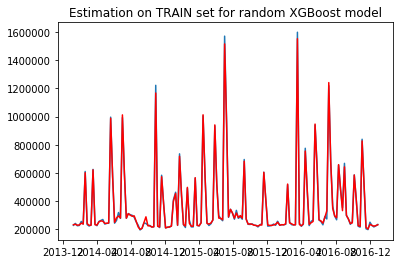

In [766]:
y_pred=xgb_fitted.predict(new_df_train)
print('---------On train set---------')
print('RMSE = {}'.format(rmse(y_pred,Y_train)))
print('MAPE = {}'.format(mean_absolute_percentage_error(Y_train, y_pred)))
print('MAE= {}'.format(metrics.mean_absolute_error(Y_train, y_pred)))
print('MSE= {}'.format(metrics.mean_squared_error(Y_train, y_pred)))
print('R2= {}'.format(metrics.r2_score(Y_train, y_pred)))

pyplot.plot(Y_train)
pyplot.plot(pd.DataFrame(index=index_train, data=y_pred), color='red')
pyplot.title('Estimation on TRAIN set for random XGBoost model')
pyplot.show()

In [767]:
df_var_importance=pd.DataFrame({'name_variable':new_df.drop('Sell_Out',axis=1).columns,'score (the higher the better)':xgb_fitted.feature_importances_})
df_var_importance.sort_values(by=['score (the higher the better)'])

,name_variable,score (the higher the better)
2,Meca_Multiple,0.000000
8,Pack_autre,0.000000
9,Pack_nan,0.000000
3,Meca_RI,0.000903
4,Meca_nan,0.001807
7,Pack_3 packs,0.003312
6,Pack_2 packs,0.018669
13,Plage,0.033725
5,Pack_1 pack,0.048479
0,Meca_Cagnottage,0.052394


# Select the predictions for all possible configurations

In [768]:
Date_to_predict='1.2017'
Week_to_predict='1'
Year_to_predict='2017'
df=pd.read_excel('/Users/newuser/Downloads/Waters.xlsx')
options_Mecanisme=df['Mecanisme'].unique().tolist()
options_Days_Uplifts=df['Days_Uplifts'].unique().tolist()
options_Plage=df['Plage'].unique().tolist()
options_Pack=df['Pack'].unique().tolist()
X_to_predict=[]
X_to_predict.append([Week_to_predict,Year_to_predict,np.nan,np.nan,np.nan,np.nan])
for meca in options_Mecanisme:
    for pack in options_Pack:
        for days_up in options_Days_Uplifts:
            for plage in options_Plage:
                if(not(pd.isnull(meca) or pd.isnull(pack) or np.isnan(days_up) or np.isnan(plage))):
                    X_to_predict.append([Week_to_predict,Year_to_predict,meca,pack,days_up,plage])
columns_x=['Week','Year','Mecanisme','Pack','Days_Uplifts','Plage']    
df_X=pd.DataFrame(columns=columns_x,data=X_to_predict)
new_X_df3=pd.get_dummies(df_X['Mecanisme'],prefix='Meca',dummy_na=True)
new_X_df4=pd.get_dummies(df_X['Pack'],prefix='Pack',dummy_na=True)
int_df2 = pd.concat([new_X_df3,new_X_df4],axis=1)
df_X=df_X.drop(['Mecanisme','Pack'],axis=1)
df_X=pd.concat([int_df2,df_X],axis=1)
df_X=df_X.fillna(0)
df_X.head(10)
#df_X contains all the possible configurations of sells for the product chosen a the begginning of this notebook 

,Meca_Cagnottage,Meca_Lots Virtuels,Meca_Multiple,Meca_RI,Meca_nan,Pack_1 pack,Pack_2 packs,Pack_3 packs,Pack_autre,Pack_nan,Week,Year,Days_Uplifts,Plage
0,0,0,0,0,1,0,0,0,0,1,1,2017,0.0,0.000000
1,0,1,0,0,0,0,1,0,0,0,1,2017,4.0,0.300000
2,0,1,0,0,0,0,1,0,0,0,1,2017,4.0,0.100000
3,0,1,0,0,0,0,1,0,0,0,1,2017,4.0,0.500000
4,0,1,0,0,0,0,1,0,0,0,1,2017,4.0,0.200000
5,0,1,0,0,0,0,1,0,0,0,1,2017,4.0,0.400000
6,0,1,0,0,0,0,1,0,0,0,1,2017,4.0,0.433333
7,0,1,0,0,0,0,1,0,0,0,1,2017,4.0,0.366667
8,0,1,0,0,0,0,1,0,0,0,1,2017,4.0,0.233333
9,0,1,0,0,0,0,1,0,0,0,1,2017,4.0,0.350000


**For the Random Forest Prediction** 
<br\><br\>
We made all the different configurations of the way to sell the next product and predicted the amount of products sold for every configuration. The following data frame is sorted. The first line correspond to the configuration the product has to be sold in order to sell the more. <br\><br\>
**For example**: <br\><br\>
If, absolutely, "1.187177e+06" products have to be sold during the week 1 in 2017, we advice to make a 6 days discount of 43% or 50% with a "two pack" and a "Lots Virtuels" configuration
<br\><br\>

In [769]:
Y_predict_rfg=rfg_fitted.predict(df_X)
pd_y=pd.DataFrame(columns=['prediction for next sell'],data=Y_predict_rfg)
X_Y=pd.concat([df_X,pd_y],axis=1)
X_Y=X_Y.sort_values(by=['prediction for next sell'], ascending=[False])
X_Y.head(10)

,Meca_Cagnottage,Meca_Lots Virtuels,Meca_Multiple,Meca_RI,Meca_nan,Pack_1 pack,Pack_2 packs,Pack_3 packs,Pack_autre,Pack_nan,Week,Year,Days_Uplifts,Plage,prediction for next sell
222,0,1,0,0,0,0,0,1,0,0,1,2017,6.0,0.433333,1.151531e+06
219,0,1,0,0,0,0,0,1,0,0,1,2017,6.0,0.500000,1.151531e+06
30,0,1,0,0,0,0,1,0,0,0,1,2017,6.0,0.500000,1.118056e+06
96,0,1,0,0,0,0,0,0,1,0,1,2017,6.0,0.433333,1.118056e+06
93,0,1,0,0,0,0,0,0,1,0,1,2017,6.0,0.500000,1.118056e+06
33,0,1,0,0,0,0,1,0,0,0,1,2017,6.0,0.433333,1.118056e+06
159,0,1,0,0,0,1,0,0,0,0,1,2017,6.0,0.433333,1.118056e+06
156,0,1,0,0,0,1,0,0,0,0,1,2017,6.0,0.500000,1.118056e+06
474,0,0,0,1,0,0,0,1,0,0,1,2017,6.0,0.433333,1.048174e+06
975,0,0,1,0,0,0,0,1,0,0,1,2017,6.0,0.500000,1.048174e+06


** Equivalently for Gradient Boosting **

In [770]:
Y_predict_xgb=GBR_fitted.predict(df_X)
pd_y=pd.DataFrame(columns=['prediction for next sell'],data=Y_predict_xgb)
X_Y=pd.concat([df_X,pd_y],axis=1)
X_Y=X_Y.sort_values(by=['prediction for next sell'], ascending=[False])
X_Y.head(10)

,Meca_Cagnottage,Meca_Lots Virtuels,Meca_Multiple,Meca_RI,Meca_nan,Pack_1 pack,Pack_2 packs,Pack_3 packs,Pack_autre,Pack_nan,Week,Year,Days_Uplifts,Plage,prediction for next sell
33,0,1,0,0,0,0,1,0,0,0,1,2017,6.0,0.433333,784655.947102
30,0,1,0,0,0,0,1,0,0,0,1,2017,6.0,0.500000,784655.947102
96,0,1,0,0,0,0,0,0,1,0,1,2017,6.0,0.433333,764391.036229
93,0,1,0,0,0,0,0,0,1,0,1,2017,6.0,0.500000,764391.036229
219,0,1,0,0,0,0,0,1,0,0,1,2017,6.0,0.500000,764391.036229
222,0,1,0,0,0,0,0,1,0,0,1,2017,6.0,0.433333,764391.036229
156,0,1,0,0,0,1,0,0,0,0,1,2017,6.0,0.500000,755415.892915
159,0,1,0,0,0,1,0,0,0,0,1,2017,6.0,0.433333,755415.892915
789,0,0,1,0,0,0,1,0,0,0,1,2017,6.0,0.433333,745883.318668
786,0,0,1,0,0,0,1,0,0,0,1,2017,6.0,0.500000,745883.318668


# Conslusion :

- A first conclusion can be made about the non effectiveness of the MAPE metric to estimate the accuracy of the model and can be seen thanks to the graph of test prediction of sells.
- Also, to predict the configurations, different results appear but the structure is conserved. 
- RMSE can be more interesting to study (in this case at least)